In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0305.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0394.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0105.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0104.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0325.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0332.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0296.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0114.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0329.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0100.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0299.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0307.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0301.JPG
/kaggle/inpu

# 3. AUTO SPLIT FUNCTION & DATA PREPARATION

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Dataset path
train_dir = "/kaggle/input/rice-leaf-diseases/rice_leaf_diseases"
label_map = {i: label for i, label in enumerate(sorted(os.listdir(train_dir)))}
label_map_reverse = {label: i for i, label in label_map.items()}
num_classes = len(label_map)

def create_dataframe(data_dir):
    data = []
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = Image.open(img_path).resize((128, 128)).convert('RGB')
                    data.append((np.array(img), label_map_reverse[label]))
                except:
                    pass
    return pd.DataFrame(data, columns=['image', 'label'])

df = create_dataframe(train_dir)

X = np.array(df['image'].tolist()) / 255.0
y = to_categorical(np.array(df['label'].tolist()), num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# 4. DATA SPLIT SUMMARY

In [7]:
print("\nDataset Split Summary")
print("-" * 50)
print(f"Training set:   {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Testing set:    {X_test.shape[0]} images")
print("Image shape:", X_train.shape[1:])
print("Number of classes:", num_classes)


Dataset Split Summary
--------------------------------------------------
Training set:   84 images
Validation set: 18 images
Testing set:    18 images
Image shape: (128, 128, 3)
Number of classes: 3


# 5. BASE MODEL + OPTIMIZER SETUP

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
input_tensor = Input(shape=(128, 128, 3))
base_model = VGG16(include_top=False, weights=None, input_tensor=input_tensor)
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output_tensor = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_tensor)

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=1e-5)

# 6. TRAINING THE MODEL

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_schedule],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)
I0000 00:00:1750107239.188885     110 service.cc:148] XLA service 0x7e1dd001a2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750107239.189665     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750107239.189684     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750107239.833024     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750107256.365127     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.3246 - loss: 1.0992 - val_accuracy: 0.3333 - val_loss: 1.0985 - learning_rate: 1.0000e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.3503 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0984 - learning_rate: 1.0000e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.2974 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0982 - learning_rate: 1.0000e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3403 - loss: 1.0976
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.3385 - loss: 1.0977 - val_accuracy: 0.3333 - val_loss: 1.0968 - learning_rate: 1.0000e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.3190 - loss: 1.0959 - val_accuracy: 0.3333 - val_loss: 1.0947 - learning_rate: 5.0000e-05
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.3190 - loss: 1.0914 - val_accu

# 7. TRAINING & VALIDATION ACCURACY

(<matplotlib.legend.Legend at 0x7e1e203a4750>,
 Text(0.5, 1.0, 'Accuracy'),
 None)

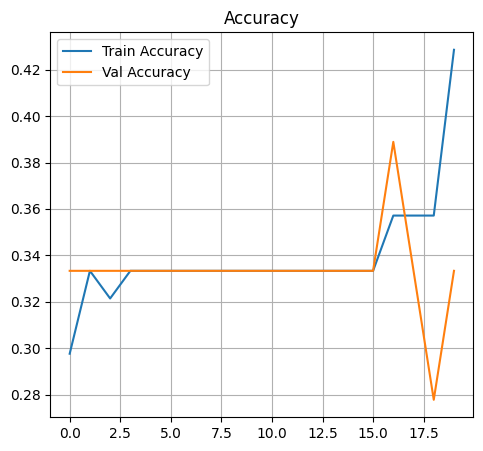

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(), plt.title('Accuracy'), plt.grid(True)

# 8. TRAINING & VALIDATION LOSS

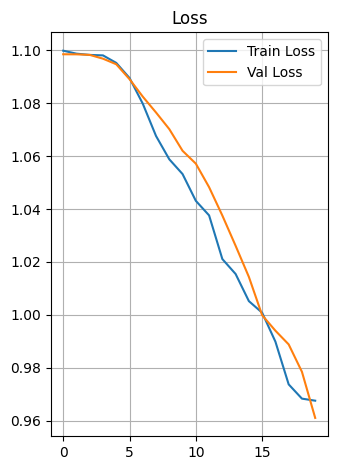

In [12]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title('Loss'), plt.grid(True)

plt.tight_layout()
plt.show()

# 9. CONFUSION MATRIX - TRAINING

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


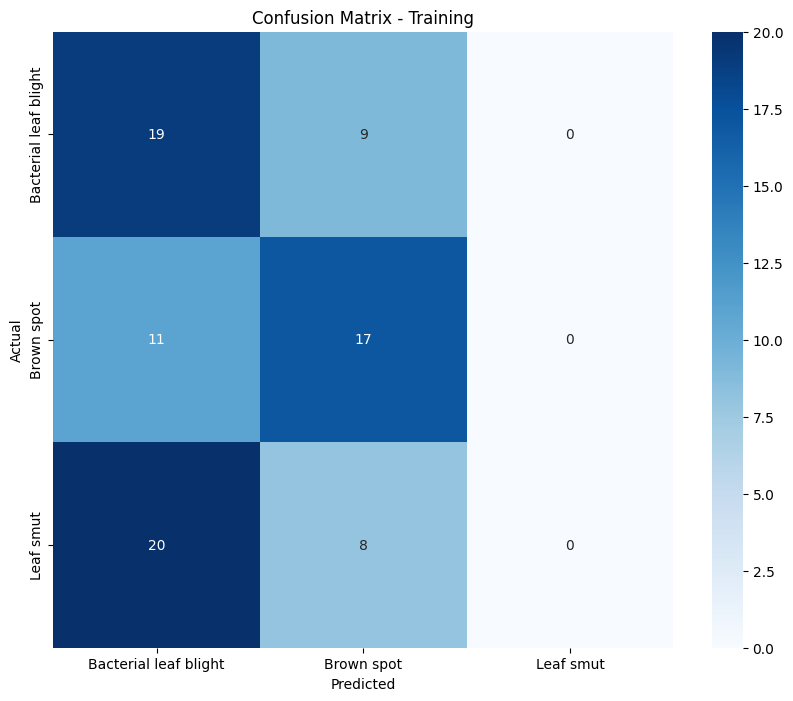

In [13]:
y_train_pred = model.predict(X_train)
y_train_pred_label = np.argmax(y_train_pred, axis=1)
y_train_true = np.argmax(y_train, axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_train_true, y_train_pred_label), annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix - Training")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10. CONFUSION MATRIX - VALIDATION

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


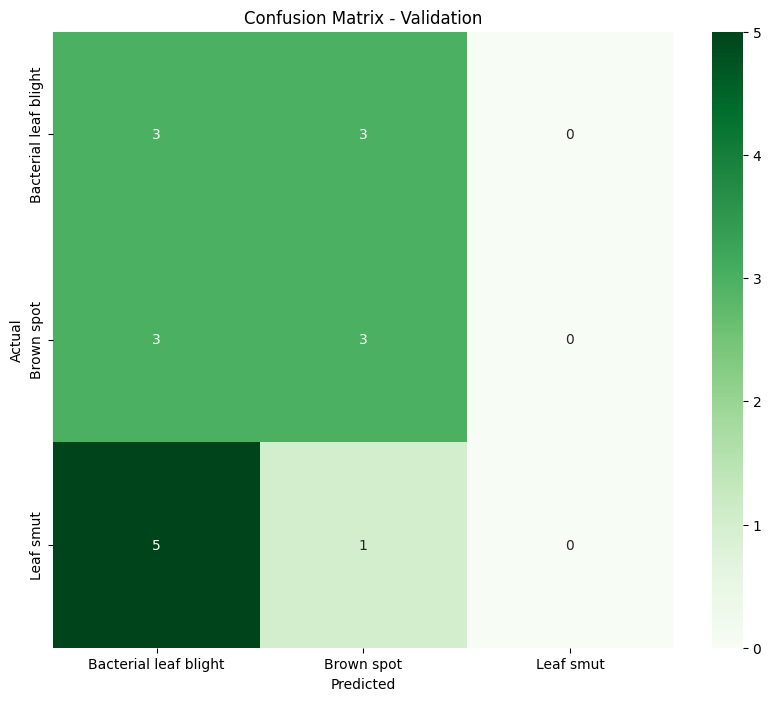

In [14]:
y_val_pred = model.predict(X_val)
y_val_pred_label = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val_true, y_val_pred_label), annot=True, fmt='d', cmap='Greens', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 11. CLASS DISTRIBUTION IN DATASET

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


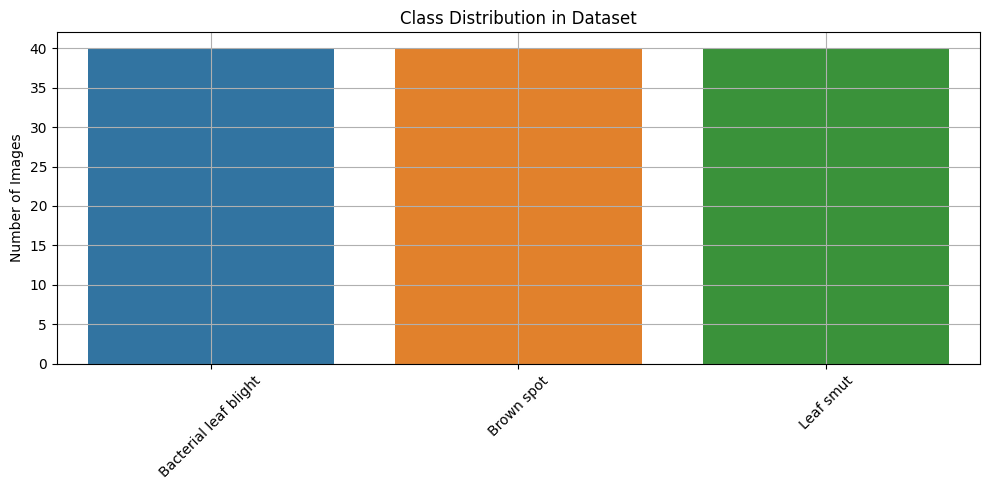

In [16]:
plt.figure(figsize=(10, 5))
class_counts = df['label'].value_counts().sort_index()
sns.barplot(x=list(label_map.values()), y=class_counts.values)
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

# 12. CLASSIFICATION REPORT

In [18]:
print(classification_report(y_val_true, y_val_pred_label, target_names=label_map.values()))

                       precision    recall  f1-score   support

Bacterial leaf blight       0.27      0.50      0.35         6
           Brown spot       0.43      0.50      0.46         6
            Leaf smut       0.00      0.00      0.00         6

             accuracy                           0.33        18
            macro avg       0.23      0.33      0.27        18
         weighted avg       0.23      0.33      0.27        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 13. ROC CURVE

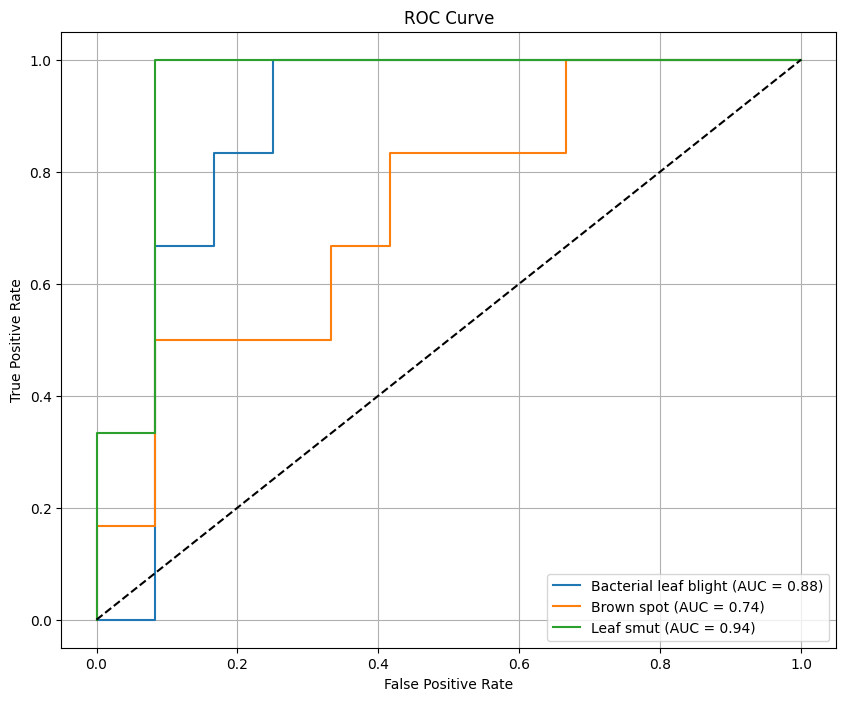

In [19]:
y_val_proba = y_val_pred
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{label_map[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# 14. PREDICTION PROBABILITY DISTRIBUTION

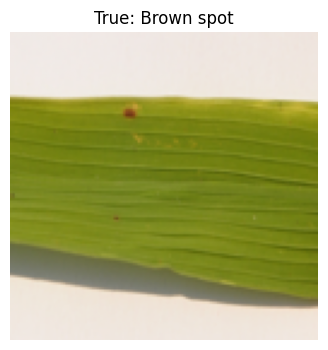

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


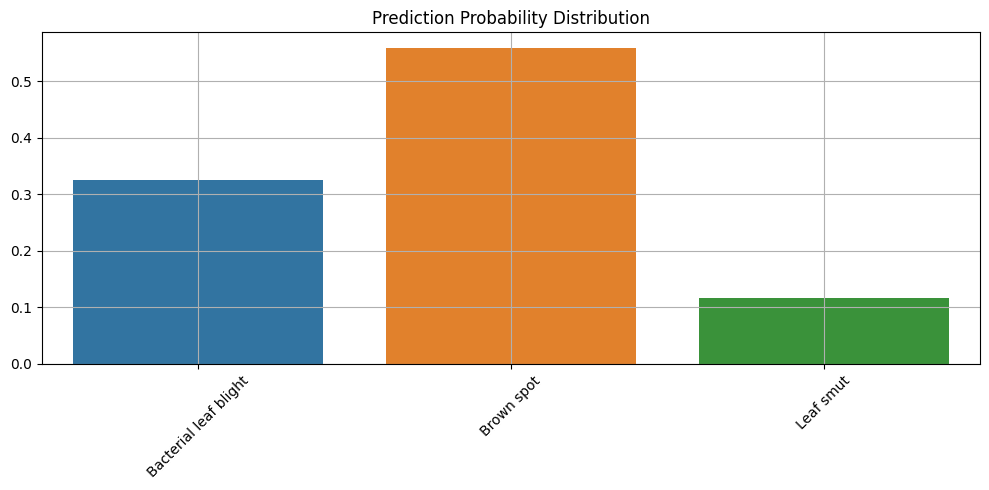

In [20]:
import random
idx = random.randint(0, len(X_val) - 1)
plt.figure(figsize=(4, 4))
plt.imshow(X_val[idx])
plt.title(f"True: {label_map[y_val_true[idx]]}")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=list(label_map.values()), y=y_val_proba[idx])
plt.title("Prediction Probability Distribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()